In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [3]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
import random
random.seed(42)
random.shuffle(words)

In [6]:
block_size = 8 

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] 

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     
Xdev, Ydev = build_dataset(words[n1:n2])  
Xte,  Yte  = build_dataset(words[n2:]) 

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [7]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])


........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [35]:
g = torch.Generator().manual_seed(2147483647)
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in **0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @self.weight;
        if self.bias is not None:
            self.out += self.bias
        
        return self.out;
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1, training=True):
        self.eps = eps;
        self.momentum = momentum
        self.training = training
        #paramaters which are trainable
        self.gamma = torch.ones(dim);
        self.beta = torch.zeros(dim);
        
        #we also maintain running mean and variance which in pytorch terminology are known as buffers
        self.running_mean = torch.zeros(dim);
        self.running_var = torch.ones(dim)
        
        
    def __call__(self, x):
        #We calc the forward pass:
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        
        #updating the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x);
        
        return self.out
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, num_embeddings, emb_dim):
        self.weight = torch.randn((num_embeddings, emb_dim))#Where weight is our C tensor
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]
    
    
class Flatten:
    def __init__(self, n):
        self.n = n
    def __call__(self,  x):
        B,T,C = x.shape
        x = x.view(B,T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    def parameters(self):
        return[]
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [36]:
n_embd = 10
n_hidden=200

model = Sequential([Embedding(vocab_size, n_embd), Flatten(2), Linear(n_embd* 2, n_hidden), BatchNorm1d(n_hidden), Tanh(),
          Flatten(2), Linear(n_hidden*2, n_hidden), BatchNorm1d(n_hidden), Tanh(),
          Flatten(2), Linear(n_hidden*2, n_hidden), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, vocab_size)
          
          ])
with torch.no_grad():
    model.layers[-1].weight *= 0.1
    for layer in model.layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # a very low weight makes the values very low and closer to zero the problem is that then we loose no linearity
            
            
parameters =  model.parameters()
for p in parameters:
    p.requires_grad = True

In [37]:

#Looking at shapes
ix = torch.randint(0, Xtr.shape[0],(4,))
Xb, Yb= Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)

torch.Size([4, 8])


In [38]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
Flatten : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
Flatten : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
Flatten : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [39]:
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [40]:
model.layers[1].out.shape
#Basically what we are doin is this
#we are taking the 3d tensor and since we have 4 example
#and in each example we have 8 characters and each character has 10dim embedding
#so we effectively concatenate these 8 characters into one long row of 8*10

torch.Size([4, 4, 20])

In [41]:
model.layers[2].out.shape

torch.Size([4, 4, 200])

In [42]:
#What we want is not to pack all 8 characters and concatenate into one
#since we have 8 characters we have to combines 2 into one
#i.e since we have 8 characters after concatenation will we will have 4 with each of size 20
#torch.randn(4,4,20) @torch.randn(20,200) + torch.randn(200).shape

In [43]:
e = torch.randn(4,8, 10)#We want this to be (4,4,20)
#One way to do this is the following
#We concatenate the even and odd parts to get out desired result
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2).shape

In [44]:
#Can also be done with the powerful view method
e.view(4,4,20)

tensor([[[ 7.9886e-01, -6.8692e-01,  5.8498e-01, -9.0750e-01,  9.3118e-01,
          -6.5530e-01, -1.2989e+00, -4.4339e-01,  8.2549e-02,  1.3110e-01,
           3.1697e-02,  8.1157e-01, -6.6976e-02, -2.4050e-02, -1.1625e+00,
           1.5287e+00,  4.7297e-01,  8.9336e-02,  9.7906e-01,  2.6772e+00],
         [ 7.6675e-01,  5.6583e-01,  2.1629e-01,  2.5408e+00, -3.6714e-01,
          -2.0768e+00, -1.2064e+00, -3.1027e-01, -1.7900e-01, -2.8957e+00,
           2.2156e-01,  2.3546e-01, -6.2659e-01, -6.8396e-01, -1.5278e+00,
          -9.9518e-01,  6.2088e-01, -6.7449e-01,  1.3241e+00, -1.2072e+00],
         [ 7.4384e-01,  1.5551e+00,  1.8146e+00,  9.3248e-01, -1.5612e+00,
           8.4986e-01, -1.2769e+00, -1.6524e+00,  1.6960e+00,  1.7173e-01,
           5.5335e-01, -1.7416e-01, -5.6899e-01, -9.3620e-01, -6.7630e-01,
           1.0958e+00,  9.7284e-01, -1.0732e+00,  3.0502e-01, -1.5161e+00],
         [-7.0776e-01,  2.6749e-01,  2.5916e+00,  5.5860e-01, -7.3644e-01,
          -5.8653e-01,

In [45]:
max_steps = 20000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    #forward pass
   
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    
    #backward pass
    
    for p in parameters:
        p.grad = None;
    loss.backward();
    lr = 0.1 if i <= 10000 else  0.01
    for p in parameters:
        p.data += -lr * p.grad
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std()/ p.data.std()).log().item() for p in parameters])
print(loss.item())
    
    
    
    

2.0460827350616455


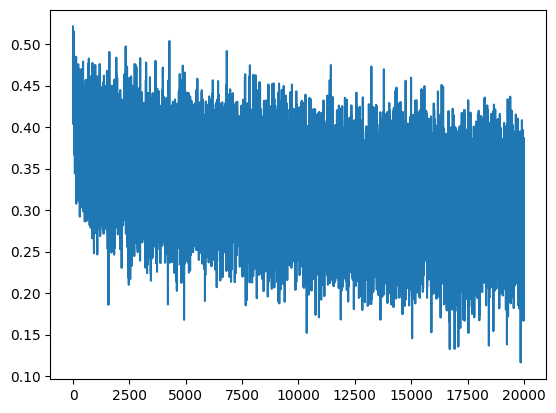

In [46]:
plt.plot(lossi)

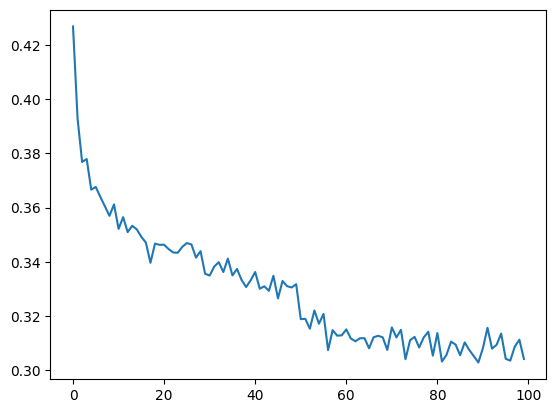

In [47]:
plt.plot(torch.tensor(lossi).view(-1, 200).mean(1))

In [48]:
for layer in model.layers:
    layer.training=False

In [49]:
@torch.no_grad
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test':(Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y);
    print(split, loss.item())
    
    
split_loss('train')
split_loss('val')


train 2.0201027393341064
val 2.068300247192383


In [50]:
for _ in range(20):
    out = [];
    context = [0] * block_size;
    while True:
        x_input = torch.tensor([context])
        logits = model(x_input)
        
        probs = F.softmax(logits, dim=1);
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

kuno.
avanden.
phaleee.
alais.
pasimne.
coha.
llaselah.
bouli.
samara.
jocas.
nnily.
laadis.
reigh.
kaidon.
briden.
jaziyahhae.
hobrij.
iolnausa.
chael.
marcenge.
